In [2]:

import cv2
import math
import shutil


import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import subprocess
import os
from PIL import Image

# from IPython import display
# display.clear_output()


# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

dataset_path = "LOCAL" #LOCAL/DRIVE

In [3]:
def show_bbox(img,boxes,axis,color=(0,255,0)):
    img=img.copy()
    for i,box in enumerate(boxes):
        box = [ round(elem) for elem in box ]
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10

    axis.imshow(img)
    axis.axis("off")

In [4]:
def extract_box(img_dict):
  boxes=[]
  for key in img_dict['image']:
    boxes.append([img_dict['xmin'][key],img_dict['ymin'][key],img_dict['xmax'][key],img_dict['ymax'][key]])
  return boxes

In [ ]:
#JUST TO SHOW BOXES EXAMPLES

# img_number=8
# img_column=2
# fig,axes=plt.subplots(int(math.ceil(img_number/img_column)),img_column,figsize=(12,12))
# plt.subplots_adjust(wspace=0.1,hspace=0.1)
# ax=axes.flatten()


# # Drive Path
# drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","archive","data")

# #Dataframe Creation
# csv_path=os.path.join(drive_dir,"train_solution_bounding_boxes (1).csv")
# df = pd.read_csv(csv_path)

# # Images From Directory
# test_imgs_dir=os.path.join(drive_dir,"training_images")
# test_img_list = os.listdir(test_imgs_dir)
# imgs_name=np.random.choice(test_img_list,img_number)
# print(imgs_name)
# print('\n\n')
# print('Loop:')
# for i,img_name in enumerate(imgs_name):
#     img_file_path=os.path.join(test_imgs_dir,img_name)
#     print(str(i)+': '+img_name)
#     img_dict=df.loc[df['image'] == img_name].to_dict()
#     print('boxes: '+str(extract_box(img_dict)))
#     img=cv2.imread(img_file_path)
#     img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     boxes=[extract_box(img_dict)]
#     show_bbox(img,boxes[0],axis=ax[i])

# plt.savefig("1.png")

In [5]:
#NORMALIZE ALL DATA RELATED MTO THE "BIGGEST" ONE, NOT TO THE IMAGES SIZES

# Drive Path
if dataset_path == "LOCAL":
    drive_dir=os.path.join(os.getcwd(), "archive","data")
elif dataset_path == "DRIVE":
    drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","archive","data")


#Dataframe Creation
csv_path=os.path.join(drive_dir,"train_solution_bounding_boxes (1).csv")

df=pd.read_csv(csv_path)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ciarp\\OneDrive\\Desktop\\Universita\\Vision & Perception\\progetto\\github\\visiope-object-detection\\archive\\data\\train_solution_bounding_boxes (1).csv'

In [5]:
# #RUNNARE SOLO UNA VOLTA

train_imgs_dir=os.path.join(drive_dir,"training_images")
labels_dir=os.path.join(drive_dir,"label")
images_dir=os.path.join(drive_dir,"image")
imgs_list=list(sorted(os.listdir(train_imgs_dir)))

# incompatible_imgs = []

# for idx, img_name in tqdm(enumerate(imgs_list)):

#     if np.isin(img_name, df_yolo["img_name"]):
#         columns=["class","x_centre","y_centre","width","height"]
#         img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values

#         label_file_path=os.path.join(labels_dir,img_name[:-4]+".txt")
#         with open(label_file_path,"w+") as f:
#             for row in img_bbox:
#                 text=" ".join(row.astype(str))
#                 f.write(text)
#                 f.write("\n")

#         old_image_path=os.path.join(train_imgs_dir,img_name)
#         new_image_path=os.path.join(images_dir,img_name)

#         #copy images from training_images to image directory
#         shutil.copy(old_image_path,new_image_path)
#     else:
#       incompatible_imgs.append(img_name)



In [ ]:
#STUFF TO CHECK DATA

# list(df_yolo["img_name"])

# # shutil.rmtree(labels_dir)
# # shutil.rmtree(images_dir)

# # os.mkdir(labels_dir)
# # os.mkdir(images_dir)

# print(len(list(os.listdir(labels_dir))))
# print(len(list(os.listdir(images_dir))))
# print(len(list(os.listdir(train_imgs_dir))))

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, S, S, 4) #4 because only 1 box is passed per time
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, S, S, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    # print("boxes_preds: ", boxes_preds.shape)
    # print("boxes_labels: ", boxes_labels.shape)

    if box_format == "midpoint" :
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # x - (w / 2)
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # y - (h / 2)
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # x + (w / 2)
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # y + (h / 2)

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners" :
        box1_x1, box1_y1 = boxes_preds[..., 0:1], boxes_preds[..., 1:2]
        box1_x2, box1_y2 = boxes_preds[..., 2:3], boxes_preds[..., 3:4]
        box2_x1, box2_y1 = boxes_labels[..., 0:1], boxes_labels[..., 1:2]
        box2_x2, box2_y2 = boxes_labels[..., 2:3], boxes_labels[..., 3:4]

    x1, y1 = torch.max(box1_x1, box2_x1), torch.max(box1_y1, box2_y1) #greater upper-left corner
    x2, y2 = torch.min(box1_x2, box2_x2), torch.min(box1_y2, box2_y2) #lower bottom-right corner


    '''
    limits the range to a lower bound of 0, so to avoid negative values.
    inter computes the area, how?
    '''

    inter = (x2-x1).clamp(0) * (y2-y1).clamp(0)

    box1_area = abs( (box1_x2 - box1_x1) * (box1_y2 - box1_y1) ) #base * altezza
    box2_area = abs( (box2_x2 - box2_x1) * (box2_y2 - box2_y1) )

    uni = box1_area + box2_area - inter

    return inter / (uni + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    avg_precisions = []
    epsilon = 1e-6 # used for numerical stability
    for c in range(num_classes):
        detections, ground_truths = [], []
        for detection in pred_boxes:
            if detection[1] == c: detections.append(detection)
        for true_box in true_boxes :
            if true_box[1] == c: ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key,val in amount_bboxes.items(): amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x:x[2], reverse=True)
        TP, FP, total_true_bboxes = torch.zeros(len(detections)), torch.zeros(len(detections)), len(ground_truths)
        if total_true_bboxes == 0:
            continue
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]
            num_gts = len(ground_truth_img)
            best_iou = 0
            for idx, gt in enumerate(ground_truth_img) :
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format=box_format,)
                if iou > best_iou :
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou > iou_threshold :
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else :
                    FP[detection_idx] = 1
            else :
                FP[detection_idx] = 1
        TP_cumsum, FP_cumsum = torch.cumsum(TP, dim=0), torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions, recalls = torch.cat((torch.tensor([1]), precisions)), torch.cat((torch.tensor([0]), recalls))
        avg_precisions.append(torch.trapz(precisions, recalls))

    return sum(avg_precisions) / (len(avg_precisions) + epsilon)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width, box[3] * height,
            linewidth=1, edgecolor="r", facecolor="none",
        )
        ax.add_patch(rect)
    plt.show()

def get_bboxes(loader, model, iou_threshold, threshold,S=7, B=2, C=1, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels,S,B,C)
        bboxes = cellboxes_to_boxes(predictions,S,B,C)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7,B=2, C=20):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """
    num_classes=C
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, B*5+C)
    bboxes1 = predictions[..., num_classes+1:num_classes+5]
    bboxes2 = predictions[..., num_classes+6:num_classes+10]
    scores = torch.cat(
        (predictions[..., num_classes].unsqueeze(0), predictions[..., num_classes+5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :num_classes].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., num_classes], predictions[..., num_classes+5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7,B=2, C=20):
    converted_pred = convert_cellboxes(out,S,B,C).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def makeCSVfile(dataset, folder):
    images = subprocess.check_output("ls "+ dataset.location + folder + '/images', shell=True, text=True).split('\n')[:-1]
    labels = subprocess.check_output("ls "+ dataset.location + folder + '/labels', shell=True, text=True).split('\n')[:-1]
    return pd.DataFrame(data = {'image': images, 'text':labels})

def save_checkpoint(state, filename="my_checkpoint.pth.tar", exit_training=False):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    if exit_training : exit()

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [45]:
# Conv2d BatchNorm2d LeakyReLU MaxPool2d

import torch
import torch.nn as nn

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # not present in the original YOLO model
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        # print(f'output shape: {x.shape}')
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        in_channels = self.in_channels
        layers = []
        for x in architecture:
            if type(x)==tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]
            elif type(x)==str:
                layers += [ nn.MaxPool2d(kernel_size=2, stride=2) ]
            elif type(x)==list:
                conv1, conv2, num_repeats = x[0], x[1], x[2]
                for i in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), #4096 in YOLO paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S*S*(B*5+C))
        )

In [51]:
architecture_config = [
    (3, 16, 1, 1),
    "M-2",
    (3, 32, 1, 1),
    "M-2",
    (3, 64, 1, 1),
    "M-2",
    (3, 128, 1, 1),
    "M-2",
    (3, 256, 1, 1),
    "M-2",
    (3, 512, 1, 1),
    "M-2",
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    (1, 1024, 1, 0)
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # not present in the original YOLO model
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov2Tiny(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        # print(f'output shape: {x.shape}')
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        in_channels = self.in_channels
        layers = []
        for x in architecture:
            if type(x)==tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]
            elif type(x)==str:
                stride = int(x.split("-")[1])
                layers += [ nn.MaxPool2d(kernel_size=2, stride=stride) ]
            elif type(x)==list:
                conv1, conv2, num_repeats = x[0], x[1], x[2]
                for i in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), #4096 in YOLO paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S*S*(B*5+C))
        )

In [9]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S, self.B, self.C = S, B, C
        self.lambda_coord, self.lambda_noobj = 5, .5

    def forward(self, predictions, target ):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5+self.C)
        ious = torch.cat(
            (intersection_over_union(predictions[...,self.C+1:self.C+5], target[...,self.C+1:self.C+5]).unsqueeze(0),  #unsqueeze(0) works only if b_size == 1
            intersection_over_union(predictions[...,self.C+6:self.C+10], target[...,self.C+1:self.C+5]).unsqueeze(0)) # target = [1, 1, x, y, w, h, 0,0,0,0,0]
                                                                                                                      #pred = [0.8, 0, 0.6, 0.8, 0.5, 0.7, 1, 0.5, 0.4,
        )

        '''
            CASE 1 CLASS:
            C+1:C+5 -> 2:6 (4) ELEMENTS
            C+6:C+10 -> 7:11 (4) ELEMENTS
            element in position [C+5] is excluded
        '''

        _, bestbox = torch.max(ious, dim=0)
        exists_box = target[...,self.C:self.C+1]

        box_predictions =  exists_box * ( (1-bestbox)*predictions[...,self.C+1:self.C+5] + bestbox*predictions[...,self.C+6:self.C+10] )
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
        box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)

        # print("box_predictions: ", box_targets.shape)
        # print("box_targets: ", box_targets.shape)
        # print("box_predictions_flatten: ", torch.flatten(box_predictions, end_dim=-2).shape)
        # print("box_targets_flatten: ", torch.flatten(box_targets, end_dim=-2).shape)

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), # batch_size*S*S, 4 e.g. (16*7*7=784, 4)
            torch.flatten(box_targets, end_dim=-2)      # batch_size*S*S, 4
        )
        '''
        object_loss is greater if my model predicted the correct box between the B possible boxes
        C:C+1 and C+5:C+6 are 1 if the chosen box is respectively the first or the second
        '''
        object_loss = self.mse(
            torch.flatten(exists_box * ( (1-bestbox)*predictions[...,self.C:self.C+1] + bestbox*predictions[...,self.C+5:self.C+6] )),
            torch.flatten(exists_box)
        )
        '''
        no_object_loss exists when no object are in the image
        else it penalize the loss when the model predicted a box or worse if the model predicted both
        '''
        no_object_loss=self.mse(
            torch.flatten((1-exists_box) * predictions[...,self.C:self.C+1], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
        ) + self.mse(
            torch.flatten((1-exists_box) * predictions[...,self.C+5:self.C+6], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
        )
        '''
        penilize if the model predicted the wrong class
        NOTE: this can be remove if the class is just one
        '''
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[...,:self.C], end_dim=-2),
            torch.flatten(exists_box * target[...,:self.C], end_dim=-2)
        )
        loss = (self.lambda_coord*box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss)
        return loss

In [20]:
class YoloLossMultiBoxes(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLossMultiBoxes, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S, self.B, self.C = S, B, C
        self.lambda_coord, self.lambda_noobj = 5, .5

    def forward(self, predictions, target ):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5+self.C)
        intersection_tuples = ()

        for i_1 in range(self.B):
            i_o_u = intersection_over_union(predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)], target[...,self.C+1:self.C+5]).unsqueeze(0)
            intersection_tuples += (i_o_u,)

        # i_o_u = intersection_over_union(target[...,self.C+1:self.C+5], target[...,self.C+1:self.C+5]).unsqueeze(0)
        # intersection_tuples += (i_o_u,)

        ious = torch.cat(intersection_tuples) # B X batch_size X S X S X self.B*5+self.C

        _, bestbox = torch.max(ious, dim=0) # Why on dimension 0 and not -1?
        exists_box = target[...,self.C:self.C+1]

        # extraction_classes = target[...,0:self.C]
        '''
        le prime C elems sono relativi a le probabilità per ogni classe,

        '''



        # print(f'bestbox: {bestbox}')
        # print(f'exists_box shape: {exists_box.shape}, bestbox shape: {bestbox.shape}, target shape: {target.shape}, target POST shape: {target[...,0].shape}, predictions shape: {predictions.shape}')

        # predictions = [
        #   [
        #     [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]], [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]]
        #   ],
        #   [
        #     [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]], [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]]
        #   ]
        # ]

        # bestbox = [
        #   [
        #     [0], [1]
        #   ],
        #   [
        #     [2], [1]
        #   ]
        # ]

        # exists_box = [
        #   [
        #     [0], [1]
        #   ],
        #   [
        #     [0], [0]
        #   ]
        # ]

        # preds_box = (1 - bestbox)
        # preds_box[preds_box != 1] = 0
        # box_predictions = preds_box * predictions[...,self.C+(1):self.C+(5)]

        pred_shape = predictions.shape[0:3]
        pred_shape = list(pred_shape)
        pred_shape.append(4)

        box_predictions = torch.zeros(pred_shape).to(DEVICE) # batch_size x S x S x 4

        for i_1 in range(self.B): #prendo solo quello relativo all'argmax
            # preds_box = ((1 + i_1) - bestbox)
            preds_box = bestbox.detach().clone()
            if i_1 == 0:
              preds_box[preds_box == i_1] = -1
              preds_box[preds_box != -1] = 0
              preds_box[preds_box == -1] = 1
            else:
              preds_box[preds_box != i_1] = 0
              preds_box[preds_box == i_1] = 1

            box_predictions += preds_box * predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)]

            # box_predictions += i_1 * predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)] # da eliminare

        box_predictions = exists_box * box_predictions
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
        box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)


        '''
            CASE 1 CLASS:
            C+1:C+5 -> 2:6 (4) ELEMENTS
            C+6:C+10 -> 7:11 (4) ELEMENTS
            element in position [C+5] is excluded
        '''

#         box_predictions =  exists_box * ( (1-bestbox)*predictions[...,self.C+1:self.C+5] + bestbox*predictions[...,self.C+6:self.C+10] )
#         box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
#         box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
#         box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)

        # print("box_predictions: ", box_targets.shape)
        # print("box_targets: ", box_targets.shape)
        # print("box_predictions_flatten: ", torch.flatten(box_predictions, end_dim=-2).shape)
        # print("box_targets_flatten: ", torch.flatten(box_targets, end_dim=-2).shape)

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), # batch_size*S*S, 4 e.g. (16*7*7=784, 4)
            torch.flatten(box_targets, end_dim=-2)      # batch_size*S*S, 4
        )
        '''
        object_loss is greater if my model predicted the correct box between the B possible boxes
        C:C+1 and C+5:C+6 are 1 if the chosen box is respectively the first or the second
        '''

        # print(f'exists_box shape: {exists_box.shape}, bestbox shape: {bestbox.shape}, target shape: {target.shape}, target POST shape: {target[...,0:1].shape}, predictions shape: {predictions.shape} predictions POST shape: {predictions[...,self.C:self.C+1].shape}')
        pred_shape = predictions.shape[0:3]
        pred_shape = list(pred_shape)
        pred_shape.append(1)
        preds = torch.zeros(pred_shape).to(DEVICE) # batch_size x S x S x 1

        for i_1 in range(self.B): #prendo solo quello relativo all'argmax
            # preds_box = ((1 + i_1) - bestbox)
            preds_box = bestbox.detach().clone()
            if i_1 == 0:
              preds_box[preds_box == i_1] = -1
              preds_box[preds_box != -1] = 0
              preds_box[preds_box == -1] = 1
            else:
              preds_box[preds_box != i_1] = 0
              preds_box[preds_box == i_1] = 1

            preds += preds_box * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)]

        preds = exists_box * preds


        # preds = target[...,0:1] * predictions[...,self.C:self.C+1]
        # for i_1 in range(1, self.B): #prendo solo quello relativo all'argmax
        #     preds += target[...,i_1:i_1+1] * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)]
        # preds = exists_box * preds

        object_loss = self.mse(
            torch.flatten(preds),
            torch.flatten(exists_box)
        )
        '''
        no_object_loss exists when no object are in the image
        else it penalize the loss when the model predicted a box or worse if the model predicted both
        '''
        no_object_loss = self.mse(
                torch.flatten((1-exists_box) * predictions[...,self.C:self.C+1], end_dim=-2),
                torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
            )
        for i_1 in range(1, self.B): #prendo solo quello relativo all'argmax
            no_object_loss += self.mse(
                torch.flatten((1-exists_box) * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)], end_dim=-2),
                torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
            )
        '''
        penilize if the model predicted the wrong class
        NOTE: this can be remove if the class is just one
        '''
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[...,:self.C], end_dim=-2),
            torch.flatten(exists_box * target[...,:self.C], end_dim=-2)
        )
        loss = (self.lambda_coord*box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss)
        return loss

In [11]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, label_dir, img_dir, S=7, B=2, C=20, transform=None):
        self.annotations = csv_file  # pd.read_csv(csv_file)
        self.label_dir, self.img_dir = label_dir, img_dir
        self.transform = transform
        self.S, self.B, self.C = S, B, C

    def __len__(self) : return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])# iloc[index, 1] return row: index, col: 1 = ".txt" filename
        image = Image.open(os.path.join(self.img_dir, self.annotations.iloc[index, 0]))
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [float(x) if float(x)!=int(float(x)) else int(float(x)) for x in label.strip().split()]
                boxes.append([class_label, x, y, width, height])

        if self.transform:
          image, boxes = self.transform(image, torch.tensor(boxes))

        label_matrix = torch.zeros(self.S, self.S, self.B*5+self.C)

        for box in boxes:
            class_label, x, y, width, height = box #.tolist()
            i, j = int(y*self.S), int(x*self.S)
            x_cell, y_cell, w_cell, h_cell= x*self.S-j, y*self.S-i, width*self.S, height*self.S #for x and y remove the integer part
            if label_matrix[i, j, self.C] == 0: #if no label has been assigned to this label, change it

                '''
                 #having only 1 class = '0', we will always have the first 2 elems = 1
                 l_m[0] => 1 (relative to the correct class)
                 l_m[1] => 1 (always 1, relative to the number of classes, relative to the existence of an object)

                 #example with 2 classes, and the first(class 0) is the correct one
                 l_m[0] => 1 (relative to the correct class)
                 l_m[1] => 0 (relative to the wrong)
                 l_m[2] => 1 (always 1, relative to the number of classes, relative to the existence of an object)

                 then we have always 8 elements relative to the bounding boxes elements

                '''

                '''

                IMPORTANT: this model can predict at most 1 box for cell, in fact is useless to have (B*5+C) it should be enough (5+C):
                1: to tell the model there is an object
                4: to specify (x, y, w, h)
                C: set to 1 the correct class
                '''

                label_matrix[i, j, self.C], label_matrix[i, j, int(class_label)] = 1, 1
                label_matrix[i, j, self.C+1:self.C+5] = torch.tensor([x_cell, y_cell, w_cell, h_cell])

        return image,label_matrix

In [12]:
def create_annotations(test_imgs_dir):
  test_img_list = os.listdir(test_imgs_dir)
  test_label_list = [s.replace(".jpg", ".txt") for s in test_img_list]

  return pd.DataFrame(data = {'image': test_img_list, 'text':test_label_list})

In [13]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
# DEVICE = "CUDA"
BATCH_SIZE = 16 # 64 in original
WEIGHT_DECAY = 0
EPOCHS = 10
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "./overfit.pth.tar"
NUM_CLASSES=1
NUM_BOXES=3
SPLIT=7
#IMG_DIR_TRAIN = f"{dataset.location.split('/')[-1]}/train/images"
#LABEL_DIR_TRAIN = f"{dataset.location.split('/')[-1]}/train/labels"
#IMG_DIR_TEST = f"{dataset.location.split('/')[-1]}/test/images"
#LABEL_DIR_TEST = f"{dataset.location.split('/')[-1]}/test/labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])



def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())


    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov2Tiny(split_size=7, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
    loss_fn = YoloLossMultiBoxes(S=7, B=NUM_BOXES, C=NUM_CLASSES)

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    annotations=create_annotations(images_dir) # LIST LIKE: 0     vid_4_1000.jpg   vid_4_1000.txt

    train_dataset=VOCDataset(annotations, labels_dir, images_dir, S=7, B=NUM_BOXES, C=NUM_CLASSES, transform=transform)


    #train_dataset = VOCDataset( makeCSVfile(dataset, '/train'),
    #                           transform=transform, img_dir=IMG_DIR_TRAIN, label_dir=LABEL_DIR_TRAIN)

    #test_dataset = VOCDataset( makeCSVfile(dataset, '/test'),
    #                          transform=transform, img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                              pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    #test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
    #                         pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    for epoch in range(EPOCHS):
        #for x, y in train_loader:
        #    x = x.to(DEVICE)
        #   for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            # import sys
            # sys.exit()

        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4, S=7, B=NUM_BOXES, C=NUM_CLASSES, device=DEVICE)
        mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")

        print(f"epoch: {epoch} Train mAP: {mean_avg_prec}")
        k=0
        if (mean_avg_prec > 0.9) and (k==0):
            k=1
            checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE, exit_training=True)
            # time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


# if __name__ == "__main__":
#     main()

In [41]:
NUM_BOXES = 2

In [52]:
# model = Yolov1(split_size=7, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
# loss_fn = YoloLoss(S=7, B=NUM_BOXES, C=NUM_CLASSES)


model = Yolov2Tiny(split_size=7, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
loss_fn = YoloLossMultiBoxes(S=7, B=NUM_BOXES, C=NUM_CLASSES)


if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

annotations=create_annotations(images_dir) # LIST LIKE: 0     vid_4_1000.jpg   vid_4_1000.txt

dataset=VOCDataset(annotations, labels_dir, images_dir, S=7, B=NUM_BOXES, C=NUM_CLASSES, transform=transform)


train_set, test_set = torch.utils.data.random_split(dataset, [300, 55])
#train_dataset = VOCDataset( makeCSVfile(dataset, '/train'),
#                           transform=transform, img_dir=IMG_DIR_TRAIN, label_dir=LABEL_DIR_TRAIN)

#test_dataset = VOCDataset( makeCSVfile(dataset, '/test'),
#                          transform=transform, img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE,
                          pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE,
                        pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)


In [57]:
# checkpoint = {
#                "state_dict": model.state_dict(),
#                "optimizer": optimizer.state_dict(),
#             }
# save_checkpoint(checkpoint, filename="drive/MyDrive/Magistrale/Visiope/object_detection/weights_tiny.pth", exit_training=True)

=> Saving checkpoint


In [ ]:
# #STUFF TO CHECK DATA

# image, label_matrix = train_dataset[0]
# i, j = int(0.4504 * 7), int(0.5398 * 7)
# print(i,j)
# k, w = (0.4504 * 7) - int(0.4504 * 7), (0.5398 * 7) - int(0.5398 * 7)
# print(k, w)
# print(image.shape, label_matrix.shape)
# label_matrix

In [53]:
map_array = []
for epoch in tqdm(range(10)):
    # index = 0

    # for x, y in train_loader:
    #     x = x.to(DEVICE)
    #     index += 1
    #     for idx in range(8):
    #         if index < 2:
    #             continue
    #         bboxes = cellboxes_to_boxes(model(x), S=7, B=2, C=1)
    #         bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    #         plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    #     # import sys
    #     # sys.exit()

    #     if index == 3:
    #         break




    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4,S=7, B=NUM_BOXES, C=NUM_CLASSES, device=DEVICE)
    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    map_array.append(mean_avg_prec.item())
    print(f"epoch: {epoch} Test mAP: {mean_avg_prec}")
    print(f"mAP Array: {map_array}")

    # print(f"epoch: {epoch} Train mAP: {mean_avg_prec}")
    # k=0
    # if (mean_avg_prec > 0.9) and (k==0):
    #     k=1
    #     checkpoint = {
    #         "state_dict": model.state_dict(),
    #         "optimizer": optimizer.state_dict(),
    #     }
    #     save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE, exit_training=True)
    #     # time.sleep(10)

    train_fn(train_loader, model, optimizer, loss_fn)


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 Test mAP: 0.0
mAP Array: [0.0]



 10%|█         | 1/10 [00:10<01:38, 10.91s/it]

Mean loss was 130.78187052408853
epoch: 1 Test mAP: 0.0
mAP Array: [0.0, 0.0]



 20%|██        | 2/10 [00:20<01:22, 10.32s/it]

Mean loss was 49.335653411017525
epoch: 2 Test mAP: 0.0
mAP Array: [0.0, 0.0, 0.0]



 30%|███       | 3/10 [00:31<01:14, 10.58s/it]

Mean loss was 29.74923939175076
epoch: 3 Test mAP: 0.001344436896033585
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585]



 40%|████      | 4/10 [00:42<01:04, 10.70s/it]

Mean loss was 22.16097248925103
epoch: 4 Test mAP: 0.4333099126815796
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796]



 50%|█████     | 5/10 [00:53<00:54, 10.94s/it]

Mean loss was 17.638904306623672
epoch: 5 Test mAP: 0.7923206090927124
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796, 0.7923206090927124]



 60%|██████    | 6/10 [01:04<00:43, 10.89s/it]

Mean loss was 14.801297982533773
epoch: 6 Test mAP: 0.912557065486908
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796, 0.7923206090927124, 0.912557065486908]



 70%|███████   | 7/10 [01:15<00:32, 10.84s/it]

Mean loss was 12.40781667497423
epoch: 7 Test mAP: 0.9585148096084595
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796, 0.7923206090927124, 0.912557065486908, 0.9585148096084595]



 80%|████████  | 8/10 [01:27<00:22, 11.19s/it]

Mean loss was 10.612722131941053
epoch: 8 Test mAP: 0.9623572826385498
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796, 0.7923206090927124, 0.912557065486908, 0.9585148096084595, 0.9623572826385498]



 90%|█████████ | 9/10 [01:39<00:11, 11.50s/it]

Mean loss was 9.269897725847033
epoch: 9 Test mAP: 0.9975906610488892
mAP Array: [0.0, 0.0, 0.0, 0.001344436896033585, 0.4333099126815796, 0.7923206090927124, 0.912557065486908, 0.9585148096084595, 0.9623572826385498, 0.9975906610488892]



100%|██████████| 10/10 [01:50<00:00, 11.06s/it]

Mean loss was 8.290643877453274


In [54]:
map_array

[0.0,
 0.0,
 0.0,
 0.001344436896033585,
 0.4333099126815796,
 0.7923206090927124,
 0.912557065486908,
 0.9585148096084595,
 0.9623572826385498,
 0.9975906610488892]

  0%|          | 0/1 [00:00<?, ?it/s]

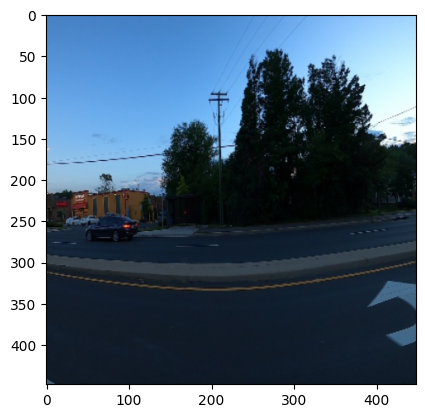

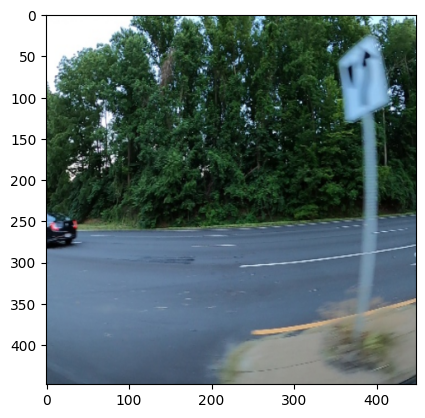

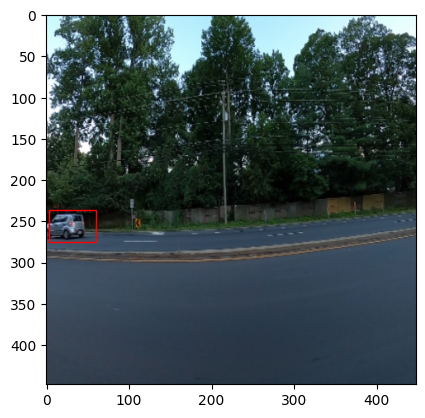

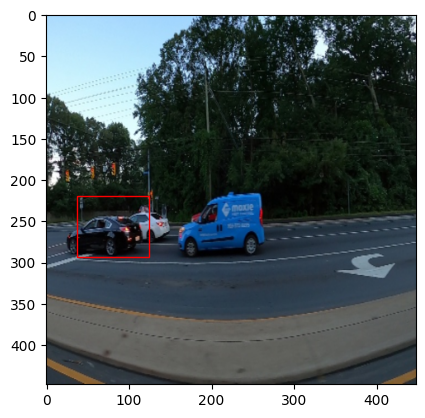

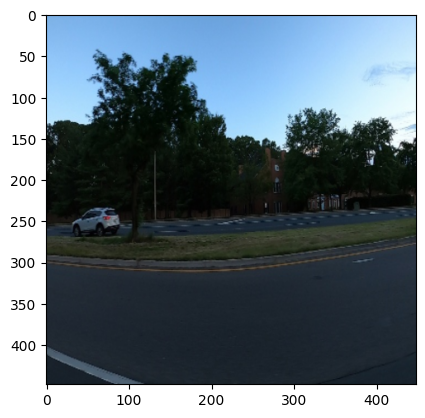

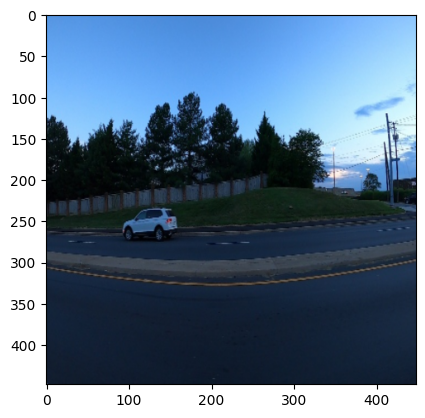

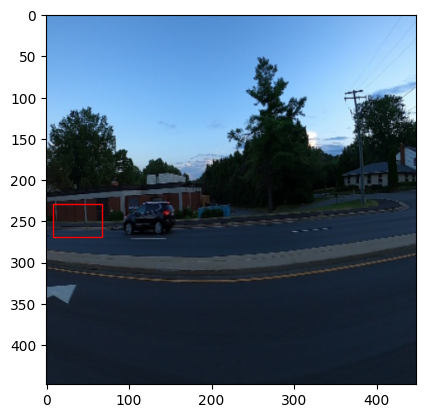

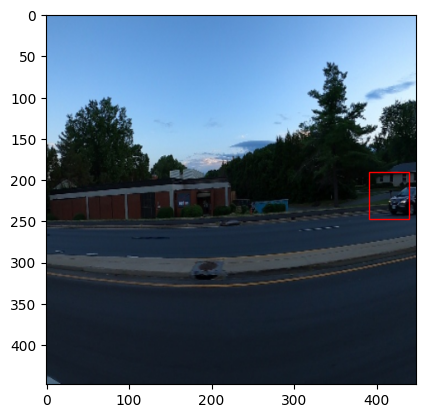

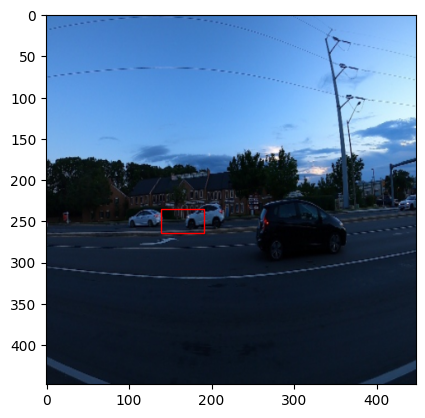

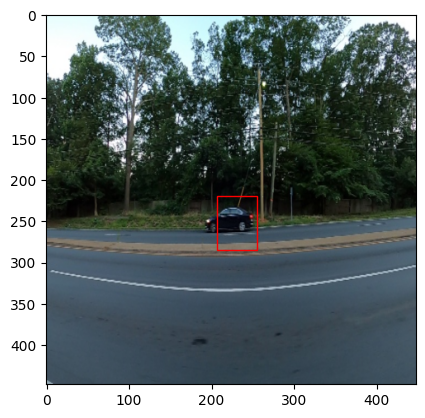

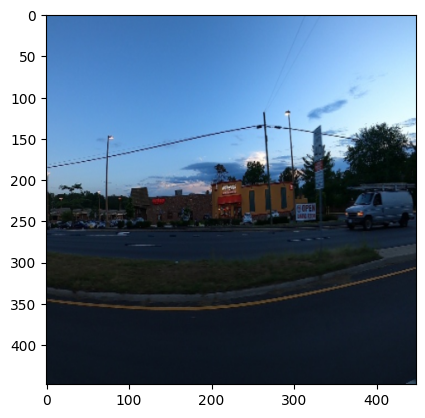

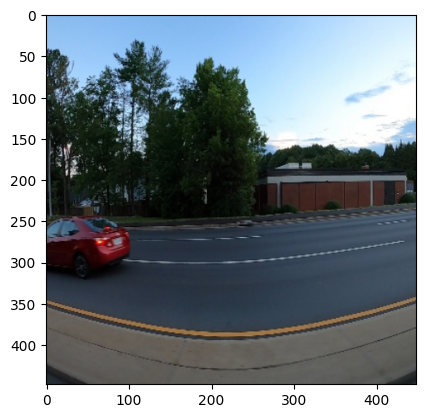

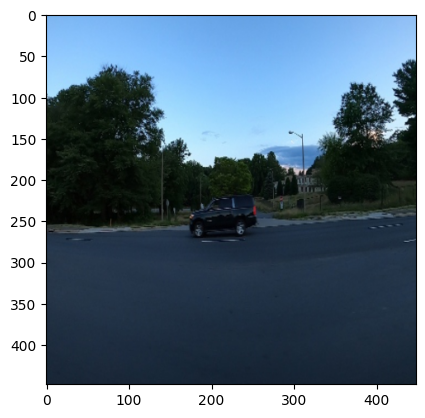

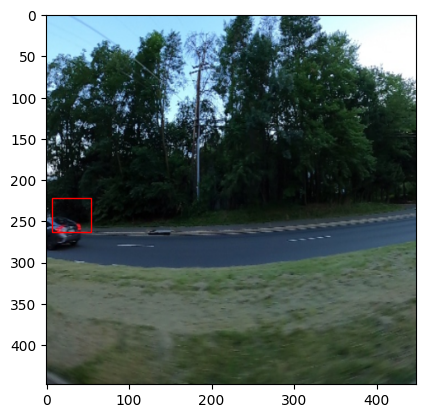

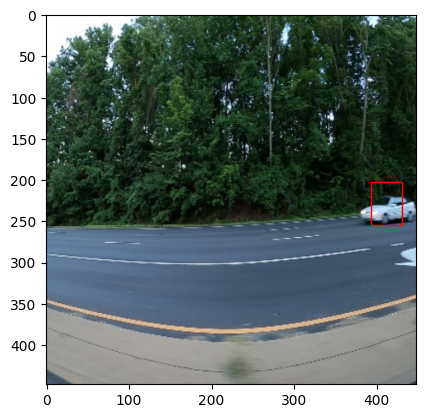

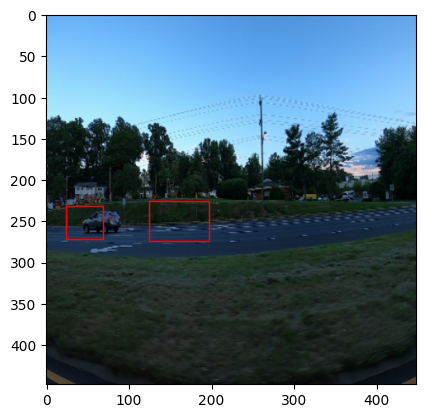

100%|██████████| 1/1 [00:08<00:00,  8.30s/it]

epoch: 0 Test mAP: 0.053308889269828796


In [56]:
map_array = []
for epoch in tqdm(range(1)):
    index = 0

    for x, y in test_loader:
        x = x.to(DEVICE)
        index += 1
        for idx in range(8):
            if index < 2:
                continue
            bboxes = cellboxes_to_boxes(model(x), S=7, B=NUM_BOXES, C=1)
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        # import sys
        # sys.exit()

        if index == 3:
            break




    pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4,S=7, B=NUM_BOXES, C=NUM_CLASSES, device=DEVICE)
    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    map_array.append(mean_avg_prec.item())
    print(f"epoch: {epoch} Test mAP: {mean_avg_prec}")
    # print(f"mAP Array: {map_array}")

    # # print(f"epoch: {epoch} Train mAP: {mean_avg_prec}")
    # # k=0
    # # if (mean_avg_prec > 0.9) and (k==0):
    # #     k=1
    # #     checkpoint = {
    # #         "state_dict": model.state_dict(),
    # #         "optimizer": optimizer.state_dict(),
    # #     }
    # #     save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE, exit_training=True)
    # #     # time.sleep(10)

    # train_fn(train_loader, model, optimizer, loss_fn)


In [ ]:
# map_array = []
# for epoch in tqdm(range(1)):
#     #for x, y in train_loader:
#     #    x = x.to(DEVICE)
#     #   for idx in range(8):
#     #        bboxes = cellboxes_to_boxes(model(x))
#     #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
#     #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

#         # import sys
#         # sys.exit()

#     pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4,S=7, B=NUM_BOXES, C=NUM_CLASSES, device=DEVICE)
#     mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
#     map_array.append(mean_avg_prec.item())
#     print(f"epoch: {epoch} Test mAP: {mean_avg_prec}")
#     print(f"mAP Array: {map_array}")

#     loop = tqdm(train_loader, leave=True)
#     mean_loss = []

#     S = 7
#     B = 3
#     C = 1


#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(DEVICE), y.to(DEVICE)
#         out = model(x)
#         target = y
#         predictions = out

#         predictions = predictions.reshape(-1, S, S, B*5+C)
#         intersection_tuples = ()

#         for i_1 in range(B - 1):
#             i_o_u = intersection_over_union(predictions[...,C+(1+i_1*5):C+(5+i_1*5)], target[...,C+1:C+5]).unsqueeze(0)
#             intersection_tuples += (i_o_u,)

#         i_o_u = intersection_over_union(target[...,C+1:C+5], target[...,C+1:C+5]).unsqueeze(0)
#         intersection_tuples += (i_o_u,)

#         ious = torch.cat(intersection_tuples) # B X batch_size X S X S X B*5+C
#         print(ious.shape)
#         print(ious.shape)

#         _, bestbox = torch.max(ious, dim=0) # Why on dimension 0 and not -1?
#         exists_box = target[...,C:C+1]




#         pred_shape = predictions.shape[0:3]
#         pred_shape = list(pred_shape)
#         pred_shape.append(4)

#         box_predictions = torch.zeros(pred_shape).to(DEVICE) # batch_size x S x S x 4
#         # print(f'bextbox: {bestbox}')
#         for i_1 in range(B): #prendo solo quello relativo all'argmax
#             # preds_box = ((1 + i_1) - bestbox)
#             preds_box = bestbox.detach().clone()
#             if i_1 == 0:
#               preds_box[preds_box == i_1] = -1
#               preds_box[preds_box != -1] = 0
#               preds_box[preds_box == -1] = 1
#             else:
#               preds_box[preds_box != i_1] = 0
#               preds_box[preds_box == i_1] = 1
#             # print(f'preds_box: {preds_box}')


#             box_predictions += preds_box * predictions[...,C+(1+i_1*5):C+(5+i_1*5)]

#             # box_predictions += i_1 * predictions[...,C+(1+i_1*5):C+(5+i_1*5)] # da eliminare

#         box_predictions = exists_box * box_predictions
#         box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
#         box_targets = exists_box * target[...,C+1:C+5] #Just these 4 because it can predicts at most 1 box for each cell
#         box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)

#         break


#     #     mean_loss.append(loss.item())
#     #     optimizer.zero_grad()
#     #     loss.backward()
#     #     optimizer.step()

#     #     # update progress bar
#     #     loop.set_postfix(loss=loss.item())


#     # print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


#     # predictions [..., self.C+1:self.C+5]
#     # predictions [..., self.C+6:self.C+10]

#     # preds = 2 - predictions
#     # preds[preds != 1] = 0
#     # preds * predictions[...,self.C+11:self.C+15]

In [ ]:
for epoch in tqdm(range(50)):
    #for x, y in train_loader:
    #    x = x.to(DEVICE)
    #   for idx in range(8):
    #        bboxes = cellboxes_to_boxes(model(x))
    #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        # import sys
        # sys.exit()

    # pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4,S=7, B=NUM_BOXES, C=NUM_CLASSES, device=DEVICE)
    # mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")

    # print(f"epoch: {epoch} Train mAP: {mean_avg_prec}")
    # k=0
    # if (mean_avg_prec > 0.9) and (k==0):
    #     k=1
    #     checkpoint = {
    #         "state_dict": model.state_dict(),
    #         "optimizer": optimizer.state_dict(),
    #     }
    #     save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE, exit_training=True)
    #     # time.sleep(10)

    train_fn(train_loader, modelV1, optimizer, loss_fn_v1)


  2%|▏         | 1/50 [00:29<24:08, 29.56s/it]

Mean loss was 442.8642203591087



  4%|▍         | 2/50 [00:59<23:38, 29.54s/it]

Mean loss was 442.0210127397017



  6%|▌         | 3/50 [01:28<23:01, 29.39s/it]

Mean loss was 438.59149169921875



  8%|▊         | 4/50 [01:57<22:28, 29.32s/it]

Mean loss was 444.2397821599787



 10%|█         | 5/50 [02:27<22:04, 29.42s/it]

Mean loss was 441.0735459761186



 12%|█▏        | 6/50 [02:56<21:38, 29.50s/it]

Mean loss was 443.6349917325106



 14%|█▍        | 7/50 [03:26<21:06, 29.46s/it]

Mean loss was 444.9939658425071



 16%|█▌        | 8/50 [03:55<20:39, 29.52s/it]

Mean loss was 442.64588789506394



 18%|█▊        | 9/50 [04:25<20:12, 29.58s/it]

Mean loss was 439.2428769198331



 20%|██        | 10/50 [04:55<19:43, 29.58s/it]

Mean loss was 443.0002080743963



 22%|██▏       | 11/50 [05:24<19:10, 29.51s/it]

Mean loss was 445.2923514626243



 24%|██▍       | 12/50 [05:54<18:41, 29.52s/it]

Mean loss was 443.63436473499644



 26%|██▌       | 13/50 [06:23<18:11, 29.51s/it]

Mean loss was 442.4857358065519



 28%|██▊       | 14/50 [06:53<17:43, 29.55s/it]

Mean loss was 441.215932672674



 30%|███       | 15/50 [07:22<17:13, 29.54s/it]

Mean loss was 446.02025812322444



 32%|███▏      | 16/50 [07:52<16:43, 29.53s/it]

Mean loss was 443.64912553267044



 34%|███▍      | 17/50 [08:21<16:15, 29.55s/it]

Mean loss was 443.4447423761541



 36%|███▌      | 18/50 [08:51<15:50, 29.69s/it]

Mean loss was 440.8890269886364



 38%|███▊      | 19/50 [09:22<15:28, 29.94s/it]

Mean loss was 442.96881797096944



 40%|████      | 20/50 [09:53<15:06, 30.20s/it]

Mean loss was 443.7840742631392



 42%|████▏     | 21/50 [10:25<14:51, 30.72s/it]

Mean loss was 442.06143465909093



 44%|████▍     | 22/50 [10:55<14:14, 30.51s/it]

Mean loss was 442.3062244762074



 46%|████▌     | 23/50 [11:24<13:37, 30.29s/it]

Mean loss was 442.3393346613104



 48%|████▊     | 24/50 [11:54<13:06, 30.24s/it]

Mean loss was 443.174052845348



 50%|█████     | 25/50 [12:25<12:37, 30.30s/it]

Mean loss was 442.2763741233132



 52%|█████▏    | 26/50 [12:55<12:06, 30.25s/it]

Mean loss was 442.73180736194956



 54%|█████▍    | 27/50 [13:25<11:32, 30.11s/it]

Mean loss was 445.15099681507456



 56%|█████▌    | 28/50 [13:55<11:04, 30.20s/it]

Mean loss was 442.3333046653054



 58%|█████▊    | 29/50 [14:25<10:32, 30.14s/it]

Mean loss was 443.6212546608665



 60%|██████    | 30/50 [14:56<10:05, 30.25s/it]

Mean loss was 441.10702375932175



 62%|██████▏   | 31/50 [15:26<09:32, 30.13s/it]

Mean loss was 441.9345078901811



 64%|██████▍   | 32/50 [15:56<09:01, 30.08s/it]

Mean loss was 441.936899358576



 66%|██████▌   | 33/50 [16:26<08:33, 30.20s/it]

Mean loss was 443.00424887917256



 68%|██████▊   | 34/50 [16:56<08:03, 30.22s/it]

Mean loss was 440.54019442471593



 70%|███████   | 35/50 [17:28<07:40, 30.73s/it]

Mean loss was 441.01851029829544



 72%|███████▏  | 36/50 [18:01<07:18, 31.32s/it]

Mean loss was 442.64682839133525



 74%|███████▍  | 37/50 [18:31<06:40, 30.84s/it]

Mean loss was 442.055156360973



 76%|███████▌  | 38/50 [19:00<06:04, 30.40s/it]

Mean loss was 440.5029005570845



 78%|███████▊  | 39/50 [19:29<05:31, 30.12s/it]

Mean loss was 442.87679776278407



 80%|████████  | 40/50 [19:59<04:59, 30.00s/it]

Mean loss was 443.4385334361683



 82%|████████▏ | 41/50 [20:29<04:28, 29.88s/it]

Mean loss was 440.39246853915125



 84%|████████▍ | 42/50 [20:58<03:58, 29.79s/it]

Mean loss was 443.2952853116122



 86%|████████▌ | 43/50 [21:27<03:27, 29.58s/it]

Mean loss was 441.4414326060902



 88%|████████▊ | 44/50 [21:57<02:57, 29.56s/it]

Mean loss was 441.92770940607244



 90%|█████████ | 45/50 [22:27<02:27, 29.59s/it]

Mean loss was 442.4857899058949



 92%|█████████▏| 46/50 [22:56<01:58, 29.65s/it]

Mean loss was 443.9382879083807



 94%|█████████▍| 47/50 [23:26<01:28, 29.58s/it]

Mean loss was 441.0315121737394



 96%|█████████▌| 48/50 [23:56<00:59, 29.62s/it]

Mean loss was 442.0440840287642



 98%|█████████▊| 49/50 [24:25<00:29, 29.71s/it]

Mean loss was 441.0678045099432



100%|██████████| 50/50 [24:55<00:00, 29.92s/it]

Mean loss was 445.0733559348366


In [ ]:
modelV1 = Yolov1(split_size=7, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
optimizerV1 = optim.Adam( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
loss_fnV1 = YoloLoss(S=7, B=NUM_BOXES, C=NUM_CLASSES)